# tsam - Basic Example

Example usage of the time series aggregation module (tsam).

This notebook demonstrates:
1. Basic k-means aggregation
2. Hierarchical aggregation with extreme periods
3. Advanced aggregation with segmentation

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os

import matplotlib.pyplot as plt
import pandas as pd

import tsam
from tsam import ClusterConfig, ExtremeConfig, SegmentConfig

# For the plotting helper function
from tsam.timeseriesaggregation import unstackToPeriods

%matplotlib inline

### Input data 

Read in time series from testdata.csv with pandas

In [2]:
raw = pd.read_csv("testdata.csv", index_col=0)

Show a slice of the dataset

In [3]:
raw.head()

,GHI,T,Wind,Load
2009-12-31 23:30:00,0,-2.1,7.1,375.478394
2010-01-01 00:30:00,0,-2.8,8.6,364.541326
2010-01-01 01:30:00,0,-3.3,9.7,357.416844
2010-01-01 02:30:00,0,-3.2,9.8,350.191306
2010-01-01 03:30:00,0,-3.2,9.4,345.161449


Show the shape of the raw input data: 4 types of timeseries (GHI, Temperature, Wind and Load) for every hour in a year

In [4]:
raw.shape

(8760, 4)

Create a plot function for the temperature for a visual comparison of the time series

In [5]:
def plotTS(data, periodlength, vmin, vmax):
    fig, axes = plt.subplots(figsize=[6, 2], dpi=100, nrows=1, ncols=1)
    stacked, timeindex = unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation="nearest", vmin=vmin, vmax=vmax)
    axes.set_aspect("auto")
    axes.set_ylabel("Hour")
    plt.xlabel("Day")

    fig.subplots_adjust(right=1.2)
    cbar = plt.colorbar(cax)
    cbar.set_label("T [°C]")

Plot an example series - in this case the temperature

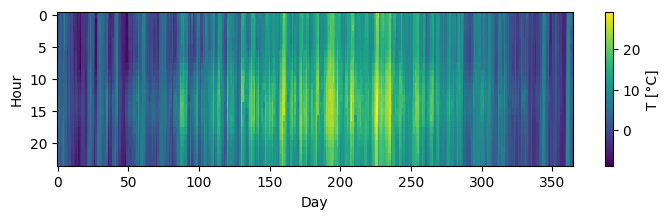

In [6]:
plotTS(raw["T"], 24, vmin=raw["T"].min(), vmax=raw["T"].max())

### Simple k-mean aggregation

Use the `aggregate()` function with k-means clustering for eight typical days.

In [7]:
result_kmeans = tsam.aggregate(
    raw,
    n_periods=8,
    period_hours=24,
    cluster=ClusterConfig(method="kmeans"),
)

Access the typical periods from the result object

In [8]:
typPeriods = result_kmeans.typical_periods
typPeriods.head()

GHI        Load         T      Wind
  TimeStep                                     
0 0         0.0  404.826677  2.871429  2.418367
  1         0.0  394.009322  2.620408  2.108163
  2         0.0  390.094367  2.467347  2.018367
  3         0.0  393.853987  2.363265  2.020408
  4         0.0  401.403694  2.300000  2.136735

Show shape of typical periods: 4 types of timeseries for 8*24 hours

In [9]:
print(f"Shape: {typPeriods.shape}")
print(
    f"Periods: {result_kmeans.n_periods}, Timesteps per period: {result_kmeans.n_timesteps_per_period}"
)

Shape: (192, 4)
Periods: 8, Timesteps per period: 24


Save typical periods to .csv file

In [10]:
typPeriods.to_csv(os.path.join("results", "testperiods_kmeans.csv"))

Reconstruct the original time series based on the typical periods

In [11]:
predictedPeriods = result_kmeans.reconstruct()

Plot the repredicted data

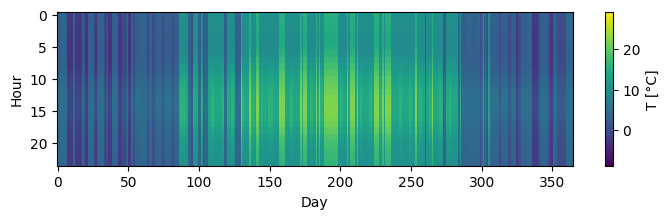

In [12]:
plotTS(predictedPeriods["T"], 24, vmin=raw["T"].min(), vmax=raw["T"].max())

As seen, they days with the minimal temperature are excluded. In case that they are required they can be added to the aggregation as follow.

### Hierarchical aggregation including extreme periods

Use hierarchical clustering with extreme period preservation. This ensures the day with the minimum temperature and maximum load are included.

In [13]:
result_hier = tsam.aggregate(
    raw,
    n_periods=8,
    period_hours=24,
    cluster=ClusterConfig(method="hierarchical"),
    extremes=ExtremeConfig(
        method="new_cluster",
        min_timesteps=["T"],  # Preserve day with minimum temperature
        max_timesteps=["Load"],  # Preserve day with maximum load
    ),
)

Create the typical periods

In [14]:
typPeriods = result_hier.typical_periods
typPeriods.head()

GHI        Load         T      Wind
  TimeStep                                     
0 0         0.0  403.253822 -0.654502  3.541068
  1         0.0  394.008077 -0.949049  4.485353
  2         0.0  389.631672 -1.047231  3.068926
  3         0.0  391.161914 -1.243596  2.832854
  4         0.0  396.952828 -1.439960  2.596783

The aggregation can also be evaluated by indicators

In [15]:
# View accuracy metrics
print(result_hier.accuracy)
print("\nRMSE per column:")
print(result_hier.accuracy.rmse)

AccuracyMetrics(
  rmse=0.1059 (mean),
  mae=0.0751 (mean),
  rmse_duration=0.0352 (mean)
)

RMSE per column:
GHI     0.093828
Load    0.099253
T       0.086290
Wind    0.144376
Name: RMSE, dtype: float64


Save typical periods to .csv file

In [16]:
typPeriods.to_csv(os.path.join("results", "testperiods_hierarchical.csv"))

Repredict the original time series based on the typical periods

In [17]:
predictedPeriodsWithEx = result_hier.reconstruct()

Plot repredicted data

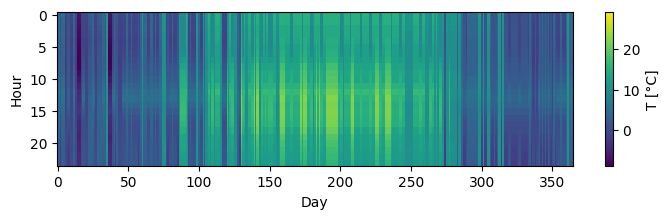

In [18]:
plotTS(predictedPeriodsWithEx["T"], 24, vmin=raw["T"].min(), vmax=raw["T"].max())

Now also the days with the minimal temperature are integrated into the typical periods.

### Advanced aggregation method

Combining hierarchical clustering with segmentation (reduced temporal resolution) and distribution-preserving representation.

In [19]:
result_advanced = tsam.aggregate(
    raw,
    n_periods=24,
    period_hours=24,
    cluster=ClusterConfig(
        method="hierarchical",
        representation="distribution_minmax",
    ),
    segments=SegmentConfig(n_segments=8),
)

In [20]:
predictedPeriodsAdvanced = result_advanced.reconstruct()

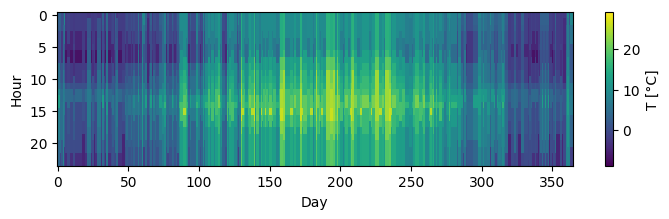

In [21]:
plotTS(predictedPeriodsAdvanced["T"], 24, vmin=raw["T"].min(), vmax=raw["T"].max())

### Comparison of the aggregations 
It was shown for the temperature, but both times all four time series have been aggregated. Therefore, we compare here also the duration curves  of the electrical load for the original time series, the aggregation with k-mean, and the hierarchical aggregation including peak periods.

Text(0, 0.5, 'Duration Load [MW]')

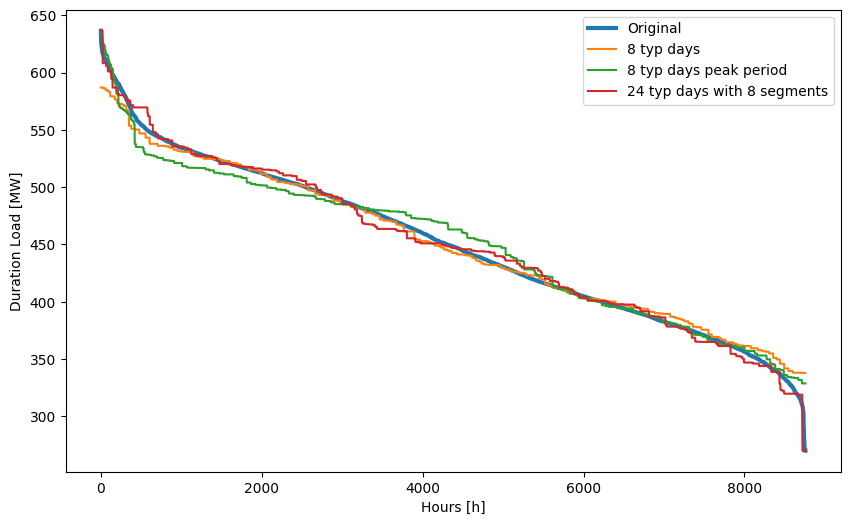

In [22]:
fig, axes = plt.subplots(figsize=[10, 6], dpi=100, nrows=1, ncols=1)
raw["Load"].sort_values(ascending=False).reset_index(drop=True).plot(
    label="Original", lw=3
)
predictedPeriods["Load"].sort_values(ascending=False).reset_index(drop=True).plot(
    label="8 typ days"
)
predictedPeriodsWithEx["Load"].sort_values(ascending=False).reset_index(drop=True).plot(
    label="8 typ days peak period"
)
predictedPeriodsAdvanced["Load"].sort_values(ascending=False).reset_index(
    drop=True
).plot(label="24 typ days with 8 segments")
plt.legend()
plt.xlabel("Hours [h]")
plt.ylabel("Duration Load [MW]")

Or as unsorted time series for an example week

Text(0, 0.5, 'Load [MW]')

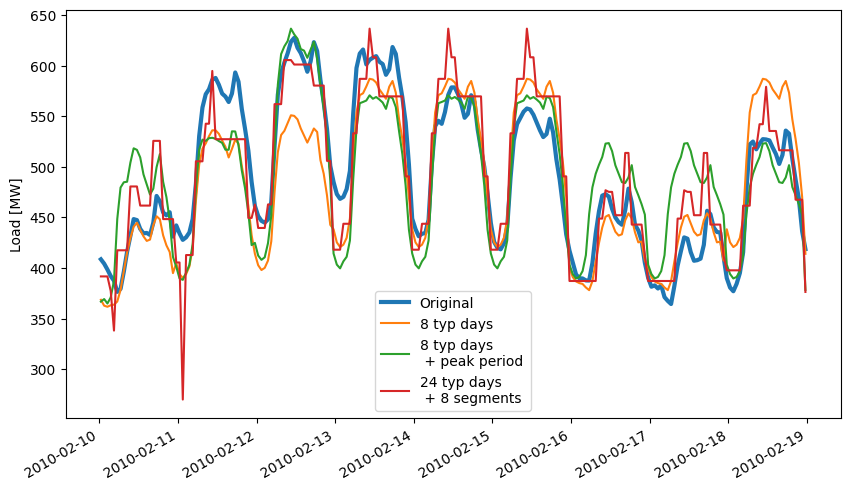

In [23]:
fig, axes = plt.subplots(figsize=[10, 6], dpi=100, nrows=1, ncols=1)
raw["Load"]["20100210":"20100218"].plot(label="Original", lw=3)
predictedPeriods["Load"]["20100210":"20100218"].plot(label="8 typ days")
predictedPeriodsWithEx["Load"]["20100210":"20100218"].plot(
    label="8 typ days \n + peak period"
)
predictedPeriodsAdvanced["Load"]["20100210":"20100218"].plot(
    label="24 typ days \n + 8 segments "
)
plt.legend()
plt.ylabel("Load [MW]")

Text(0, 0.5, 'Solar irradiance [W/m2]')

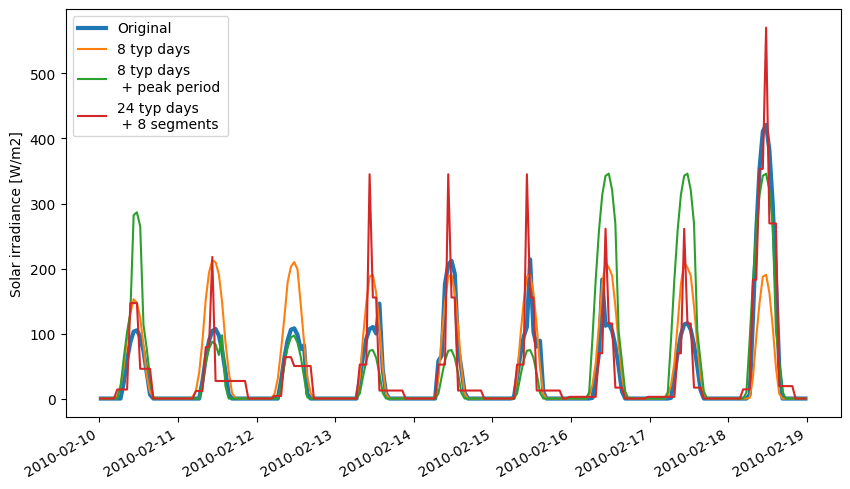

In [24]:
fig, axes = plt.subplots(figsize=[10, 6], dpi=100, nrows=1, ncols=1)
raw["GHI"]["20100210":"20100218"].plot(label="Original", lw=3)
predictedPeriods["GHI"]["20100210":"20100218"].plot(label="8 typ days")
predictedPeriodsWithEx["GHI"]["20100210":"20100218"].plot(
    label="8 typ days \n + peak period"
)
predictedPeriodsAdvanced["GHI"]["20100210":"20100218"].plot(
    label="24 typ days \n + 8 segments "
)
plt.legend()
plt.ylabel("Solar irradiance [W/m2]")